In [1]:
from PIL import Image
import glob
import numpy as np

In [2]:
def load_images(dir_name):
    output_images = []
    for image_name in glob.glob(dir_name + '/*'):
        image = Image.open(image_name).resize((224,224))
        output_image_data = np.asarray(image, dtype='float32') / 255.0
        if output_image_data.shape == (224,224,3):
            output_images.append(output_image_data)
    return np.array(output_images)

In [3]:
neutral_img = load_images('data/train/neutral')
happy_img = load_images('data/train/happy')
X = np.concatenate((neutral_img, happy_img), axis=0)

In [4]:
import keras
num_classes = 2
y = np.concatenate((np.zeros(neutral_img.shape[0]), np.ones(happy_img.shape[0])))
y = keras.utils.to_categorical(y,num_classes)

/Users/cheunghoyeung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=.2,random_state=42)

In [6]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)

In [7]:
from matplotlib import pyplot
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
# create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'));
    # show the plot
    pyplot.show();
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 9 Axes>

In [8]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [9]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer and a logistic layer 
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first train only the top layers (which were randomly initialized)
# freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# compile the model after setting layers to non-trainable
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train)/128, epochs=5)

Epoch 1/5
2/1 [================================] - 49s 24s/step - loss: 2.8939
Epoch 2/5
2/1 [================================] - 45s 22s/step - loss: 7.5369
Epoch 3/5
2/1 [================================] - 47s 23s/step - loss: 5.2798
Epoch 4/5
2/1 [================================] - 50s 25s/step - loss: 4.8786
Epoch 5/5
2/1 [================================] - 53s 27s/step - loss: 4.6343


In [11]:
# start fine-tuning convolutional layers from Inception3
# will freeze the bottom N layers and train the remaining top layers.
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# freeze the first 25 layers and unfreeze the rest:
for layer in model.layers[:25]:
    layer.trainable = False
for layer in model.layers[25:]:
    layer.trainable = True

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [12]:
# recompile the model for these modifications to take effect
# use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                    steps_per_epoch=len(X_train)/128, epochs=5,
                    validation_data=datagen.flow(X_val, y_val, batch_size=50))

Epoch 1/5
2/1 [================================] - 167s 84s/step - loss: 4.4495 - acc: 0.5891 - val_loss: 3.6057 - val_acc: 0.5083
Epoch 2/5
2/1 [================================] - 141s 70s/step - loss: 2.4675 - acc: 0.6826 - val_loss: 0.6412 - val_acc: 0.5750
Epoch 3/5
2/1 [================================] - 132s 66s/step - loss: 0.2986 - acc: 0.9266 - val_loss: 0.5454 - val_acc: 0.7917
Epoch 4/5
2/1 [================================] - 125s 62s/step - loss: 0.1196 - acc: 0.9684 - val_loss: 0.9654 - val_acc: 0.9000
Epoch 5/5
2/1 [================================] - 133s 66s/step - loss: 0.0856 - acc: 0.9880 - val_loss: 0.3999 - val_acc: 0.9500


In [15]:
# Save the model
model.save('inception_v3_data_flow.h5')

In [21]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

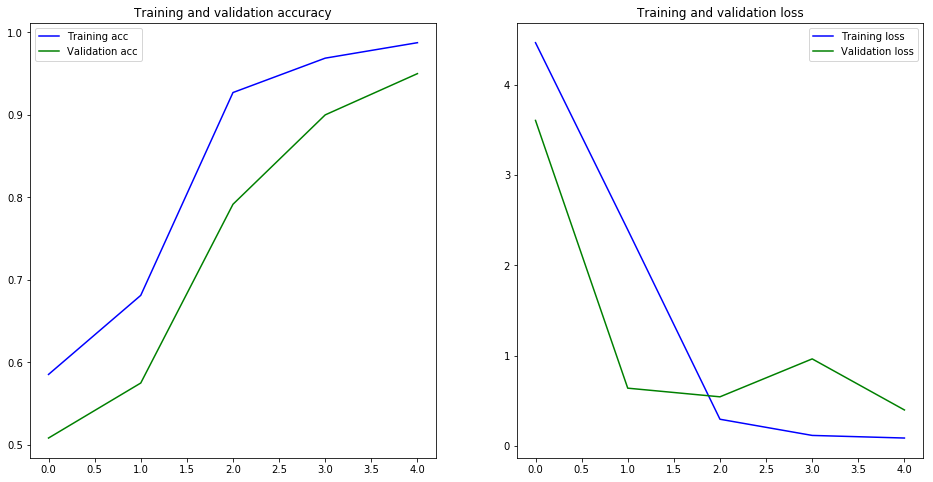

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(acc, 'b', label='Training acc')
axes[0].plot(val_acc, 'g', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(loss, 'b', label='Training loss')
axes[1].plot(val_loss, 'g', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()

plt.show()

In [14]:
score, acc = model.evaluate_generator(datagen.flow(X_val, y_val, batch_size=50))
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.39986122244348127
Test accuracy: 0.9499999980131785


In [ ]:
#model.predict_generator(datagen.flow(X_test, y_test, batch_size=50))